Performance tests

Performance analysis - date structure to store particles in cells
Needs :
- delete (for advection phase)
- add
- get (for collisisons)

Ideally, we want only $O(1)$

Conclusion : 
While python seems faster than numpy array with the small examples I made, it is because each time we do a *get* or a *add* or a remove, we do not use the fact that the memory is contiguous for numpy array. We do one at a time. Thus, python list is faster by a factor 2 relativley to numpy array.

However as soon as we want to remove several contiguous particles at a time, or get add several contiguous particles, then the numpy array "retake the lead".

For our use case, there is no preference for one or the other. We use both cases even though only on one element most of the time.

However, the advantage of using array numpy comes from the possiblity to easily parallize and cythonize it in the future. If we do that, we should not get too big an overhead while converting and we would go much faster.

In [ ]:
from src.utils import LinkedList
import numpy as np
from time import time

In [ ]:
class Array(object):
    def __init__(self, shape, dtype = int):
        self.arr = np.empty(shape, dtype = dtype)
        self.init_shape = shape
        self.max_size = shape[0]
        self.elements_nb = 0
        
    def add(self, o):
        if(self.elements_nb >= self.max_size):
            print(f'Max size reach. Changing size from {self.max_size} to {self.max_size+self.init_shape[0]}')
            self.arr = np.concatenate([self.arr, self.empty(shape, dtype = dtype)])
        self.arr[self.elements_nb] = o
        self.elements_nb += 1   

    def add_multiple(self, new_arr):
        if(self.elements_nb+new_arr.shape[0] > self.max_size):
            print(f'Max size reach. Changing size from {self.max_size} to {self.max_size+self.init_shape[0]}')
            self.arr = np.concatenate([self.arr, self.empty(shape, dtype = dtype)])
        self.arr[self.elements_nb:self.elements_nb+new_arr.shape[0]] = new_arr
        self.elements_nb += new_arr.shape[0]   

    def remove(self, idx):
        self.elements_nb -= 1
        self.arr[idx] = self.arr[self.elements_nb]
    we dont do remove multiple as we will never use it in practice
    def get(self, idx):
        return self.arr[idx]

class PythonList(object):
    def __init__(self):
        self.arr = []
        self.elements_nb = 0
        
    def add(self, o):
        self.arr.append(o)
        self.elements_nb += 1   
    
    def remove(self, idx):
        self.elements_nb -= 1
        self.arr.pop(idx)
    
    def get(self, idx):
        return self.arr[idx]

In [ ]:
arr = Array((1000,2)) max size is 1000
linkedlist = LinkedList()
mylist = PythonList()

In [ ]:
def test_add(particle, structure):
    structure.add(particle)

In [ ]:
import timeit
part = np.array([1,1], dtype = int)
%timeit lambda : arr.add(part)
%timeit lambda : linkedlist.insert(part)
%timeit lambda : mylist.add(part)

In [ ]:
particles = np.random.randint(low=0, high = 100, size = (500,2), dtype = int)
for part in particles:
    arr.add(part)
    linkedlist.insert(part)
    mylist.add(part)

In [ ]:
particles[100]

In [ ]:
%timeit lambda : arr.get(100)
%timeit lambda : linkedlist.get(100)
%timeit lambda : mylist.get(100)

In [ ]:
%timeit lambda : arr.remove(100)
%timeit lambda : linkedlist.remove(array([ 4, 52]))
%timeit lambda : mylist.remove(100)

In [ ]:
from time import time

t0 = time()
t1 = t0
for k in range(100000):
    tmp = time()
    mylist.get(100)
    t1 += time()-tmp
print(t1-t0)

t0 = time()
t1 = t0

for k in range(100000):
    tmp = time()
    arr.get(100)
    t1 += time()-tmp

print(t1-t0)

t0 = time()
t1 = t0
for k in range(100000):
    tmp = time()
    linkedlist.get(100)
    t1 += time()-tmp

print(t1-t0)

In [ ]:
from time import time

t0 = time()
t1 = t0
for k in range(100000):
    mylist.add(np.array([10,10]))
    tmp = time()
    mylist.remove(100)
    t1+=time()-tmp
print(t1-t0)

t0 = time()
t1 = t0
for k in range(100000):
    arr.add(np.array([10,10]))
    tmp = time()
    arr.remove(100)
    t1+=time()-tmp
print(t1-t0)

t0 = time()
t1 = t0
for k in range(100000):
    linkedlist.insert(np.array([10,10]))
    tmp = time()
    linkedlist.remove(100)
    t1+=time()-tmp
print(t1-t0)

In [ ]:
particles_list = [part for part in particles]
t0 = time()
t1 = t0
for k in range(100000):
    tmp = time()
    particles_list[100:200]
    t1 += time()-tmp
print(t1-t0)

t0 = time()
t1 = t0

for k in range(100000):
    tmp = time()
    particles[100:200]
    t1 += time()-tmp

print(t1-t0)

##Add multiple

In [ ]:
t0 = time()
t1 = t0
for k in range(100000):
    tmp = time()
    for part in particles:
        mylist.add(part)
    t1 += time()-tmp
    for k in range(len(particles)):
        mylist.remove(0)
print(t1-t0)

t0 = time()
t1 = t0

for k in range(100000):
    tmp = time()
    arr.add_multiple(particles)
    t1 += time()-tmp
    for k in range(len(particles)):
        arr.remove(0)
print(t1-t0)

#Testing expr

In [ ]:
import numexpr
import numpy as np

In [ ]:
walls = np.array([[-1,1,1,1], [1,1,1,1]])
arr = np.array([[1,1,1,1,0], [2,1,-1,-1,0]])
print(arr)

In [ ]:
dp = walls[:,:2]-walls[:,2:]
supposing dp.x > 0
ctheta, stheta = dp[:,0], dp[:,1]
x, y, vx, vy, vz = np.split(arr, indices_or_sections=5, axis = 1)
b = numexpr.evaluate("-vx*stheta+vy*ctheta")  -velocity.x*stheta+velocity.y*ctheta

#Collisions with wall

In [ ]:
from src.utils import handler_wall_collision, make_collisions, make_collisions_vectorized
import numpy as np
N = 1000
walls = np.array([[0,0,1,0], [0,0,0,1], [1,0,1,1], [0,1,1,1]])
a = np.array([[1,0, 1],[0,1, 1],[0,1, 1],[1,0, 1]])
arr =  np.random.random((N,5)) np.array([[2,0.5,1,0,0], [0.5,2,0,1,0], [2,2,1,1,0], [0.5,0.5,1,0,0], [0.5,0.5,-1,0,0]]*N)
radius = 0.1
print(arr.shape)

In [ ]:
import timeit
%timeit lambda : make_collisions(np.copy(arr), walls, a, ct, cp) not to sure about this one
%timeit lambda : make_collisions_parallel(np.copy(arr), walls, a, ct, cp)

In [ ]:
from time import time 
from tqdm import tqdm

def perf_N(tries=100):

    N_list = [1,10, 100, 1000, 10000]

    walls = np.array([[0,0,1,0], [0,0,0,1], [1,0,1,1], [0,1,1,1]])
    a = np.array([[1,0, 1],[0,1, 1],[0,1, 1],[1,0, 1]])

    radius = 0.1
    L1, L2 = [], []
    
    for N in N_list :
        t1 = 0
        t2 = 0
        for k in tqdm(range(tries)):
            arr = np.random.random((N,5))
            ct, cp = handler_wall_collision(arr, walls, a, radius)
            arr1 = np.copy(arr)
            arr2 = np.copy(arr)

            tmp = time()
            make_collisions(arr1, a, ct, cp)
            t1+= time()-tmp

            tmp = time()
            make_collisions_vectorized(arr2, a, ct, cp)
            t2+= time()-tmp
        L1.append(t1)
        L2.append(t2)
    return N_list, np.array(L1)/tries, np.array(L2)/tries

def perf_walls(tries=100):

    def wall_builders(N):
        split = N//4 
        l = 1.0/split
        walls = []
        a = np.array(split*[[1,0, 1],[0,1, 1],[0,1, 1],[1,0, 1]])
        for k in range(split):
            w1 = [k*split, 0, (k+1)*split, 0]
            w2 = [0, k*split, 0, (k+1)*split]
            w3 = [1, k*split, 1, (k+1)*split]
            w4 = [k*split, 1, (k+1)*split, 1]
            walls.append(w1)
            walls.append(w2)
            walls.append(w3)
            walls.append(w4)
        return np.array(walls), a

    N = 1000
    walls_number = [4, 8, 16, 32, 64, 128]     we will keep a square

    radius = 0.1
    L1, L2 = [], []
    for nb in walls_number :
        t1 = 0
        t2 = 0
        for k in tqdm(range(tries)):
            arr = np.random.random((N,5))
            walls, a = wall_builders(nb)

            ct, cp = handler_wall_collision(arr, walls, a, radius)

            arr1 = np.copy(arr)
            arr2 = np.copy(arr)

            tmp = time()
            make_collisions(arr1, a, ct, cp)
            t1+= time()-tmp

            tmp = time()
            make_collisions_vectorized(arr2, a, ct, cp)
            t2+= time()-tmp
        L1.append(t1)
        L2.append(t2)
    return walls_number, np.array(L1)/tries, np.array(L2)/tries

In [ ]:
N, L1, L2 = perf_N() 
import matplotlib.pyplot as plt
plt.plot(N, L1, 'r')
plt.plot(N, L2, 'b')
plt.yscale('log')
plt.xscale('log')

In [ ]:

N, L1, L2 = perf_walls() perf_walls()
import matplotlib.pyplot as plt
plt.plot(N, L1, 'r')
plt.plot(N, L2, 'b')
plt.yscale('log')
plt.xscale('log')

# Hard reset vs Update of the grid 

The goal is to measure how long it takes to update the grid vs hard resetting it for various number of particles and particles to delete.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np

In [2]:
import timeit
import time

def _template_func(setup, func):
    """Create a timer function. Used if the "statement" is a callable."""
    def inner(_it, _timer, _func=func):
        setup()
        _t0 = _timer()
        for _i in _it:
            retval = _func()
        _t1 = _timer()
        return _t1 - _t0, retval
    return inner

timeit._template_func = _template_func

In [3]:
import lppydsmc as ld
def performance_comparison(N = 1000, rate_out = 0.05):
    resolutions = np.array([10,10], dtype = int)
    offsets = np.array([0,0])
    system_shape = np.array([100, 100])
    
    container = ld.data_structures.Container(size_array = N, number_of_elements = 5, dtype=float)
    grid = ld.data_structures.Grid(100, max_number_per_cell = int(10*N//100))
    positions_in_grids_save = ld.data_structures.Container(size_array = N, number_of_elements = 0, dtype=int)
    
     
    arr = np.random.randint(low = 0, high = 100, size = (N,5)) # with int
    idxes_out = np.random.randint(low = 0, high = N, size = (int(rate_out*N))) # selecting certain 
    new_positions = ld.data_structures.grid.default_hashing(ld.data_structures.grid.pos_in_grid(arr[:,:2], resolutions, offsets, system_shape), res_y = resolutions[1])
    
    container.add_multiple(arr)
        
    n2 = container.get_current()
    
    ############################
        # adding new particles to grid
    positions = ld.data_structures.grid.default_hashing(ld.data_structures.grid.pos_in_grid(arr[:,:2], resolutions, offsets, system_shape), res_y = resolutions[1])
    parts_in_grid_format = ld.data_structures.grid.convert_to_grid_format(new = n2)
    grid.add_multiple(positions, parts_in_grid_format)
    
        # and to the positions in grid saver
    positions_in_grids_save.add_multiple(positions)    
    ############################
    
        
    def hard_reset():
        container.delete_multiple(idxes_out)
        grid.reset()
        parts_in_grid_format = ld.data_structures.grid.convert_to_grid_format(new = new_positions.shape[0])
        grid.add_multiple(positions, parts_in_grid_format)
    
    def update_grid():
        idxes_out_ = np.sort(idxes_out) # required here
        count = idxes_out_.shape[0]-1
        
        for idx in range(container.get_current()-1, -1, -1):
            old_pos = positions_in_grids_save.get(idx)
            new_pos = new_positions[idx]
            
            if(idxes_out.size > 0 and idx == idxes_out_[count]):
                # particle is outside
                # we have to delete it
                current = container.get_current() # current changes with each delete !
                count -= 1

                # swapping it with the last one in the container
                container.delete(idx)
                positions_in_grids_save.delete(idx)
                # deleting the object in the grid
                grid.remove(old_pos, np.array([0,idx], dtype = int)) # since [idx container, idx] is a unique key, we check for equality in values of the array (not in references)

                # updating the swapped particle in the grid
                swapping_particle_pos = positions_in_grids_save.get(idx) # this supposes that positions_in_grids_save is up-to-date for the particle previously at index 'current-1' (and now at index 'idx'). 
                # this is why we are iterating from the end
                grid.update_index(swapping_particle_pos, idx_container = 0, old_index = current-1, new_index = idx)
            elif(np.array_equal(old_pos, new_pos)):
                pass
            else:
                # then the particle does not need to be deleted, just updated
                grid.update(o = np.array([0,idx]), old_pos = old_pos, new_pos = new_pos) # in theory it should not changed the value of the object (indeed, its position in the grid should not have changed !)
                # and update the new positions in grid in the saver
                positions_in_grids_save.update(idx, new_pos)
        
        

    #t1 = timeit.Timer(hard_reset)
    #time1 = t1.timeit(number=1) # this is the time it took

    #t2 = timeit.Timer(update_grid)
    #time2 = t2.timeit(number=1) # this is the time it took
    from time import time
    t1 = time()
    hard_reset()
    t1 = time()-t1

    t2 = time()
    update_grid()
    t2 = time()-t2
    
    return t1,t2


In [4]:
t1, t2 = performance_comparison()

In [5]:
from tqdm import tqdm
T1, T2 = [], []
list_N = [1e3,1e4,1e5,1e6,3e6, 5e6, 7e6, 1e7]
for N in tqdm(list_N):
    N = int(N)
    t1, t2 = performance_comparison(N, rate_out = 0.01) # in fact its more 1% for the tube
    T1.append(t1)
    T2.append(t2)

100%|██████████| 8/8 [06:04<00:00, 45.54s/it]


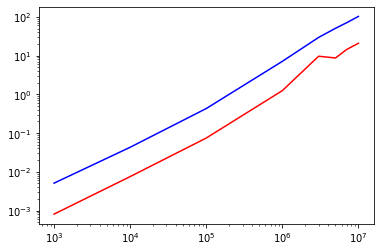

In [6]:
import matplotlib.pyplot as plt
plt.plot(list_N, T1, 'r')
plt.plot(list_N, T2, 'b')
plt.yscale('log')
plt.xscale('log')